# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

### Признаки
DateCrawled — дата скачивания анкеты из базы\
VehicleType — тип автомобильного кузова\
RegistrationYear — год регистрации автомобиля\
Gearbox — тип коробки передач\
Power — мощность (л. с.)\
Model — модель автомобиля\
Kilometer — пробег (км)\
RegistrationMonth — месяц регистрации автомобиля\
FuelType — тип топлива\
Brand — марка автомобиля\
NotRepaired — была машина в ремонте или нет\
DateCreated — дата создания анкеты\
NumberOfPictures — количество фотографий автомобиля\
PostalCode — почтовый индекс владельца анкеты (пользователя)\
LastSeen — дата последней активности пользователя\
### Целевой признак
Price — цена (евро)\

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, date, time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

from datetime import datetime 

import warnings

In [2]:
RANDOM_STATE = 11
warnings.filterwarnings("ignore")

### Анализ данных

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
non_numeric = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for feature in non_numeric:
    display (feature)
    display(df[feature].unique())

'VehicleType'

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

'Gearbox'

array(['manual', 'auto', nan], dtype=object)

'Model'

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

'FuelType'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

'Brand'

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

'NotRepaired'

array([nan, 'yes', 'no'], dtype=object)

### Подготовка данных

#### "Год регистрации"
Исключим выбросы

Посмотрим, когда были созданы последние анкеты, чтобы исключить автомобили с годом регистрации позже этой даты.

In [5]:
df['DateCreated'].max()

'2016-04-07 00:00:00'

Посмотрим распределение года регистрации

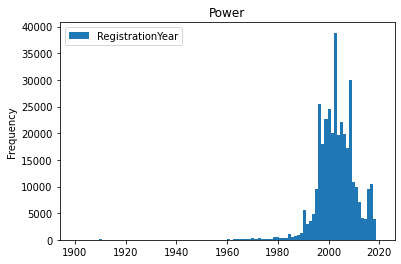

In [6]:
df.plot(kind='hist', y='RegistrationYear', bins = 100, title='Power', range=(1900, 2020))
plt.show( )

Видим, что авто с регистрацией до 1960 года практически нет. Уберем возможные выбросы до 1960 года и после 2016 года

In [7]:
df = df[df['RegistrationYear']>1960]
df = df[df['RegistrationYear']<2017]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339229 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        339229 non-null  object
 1   Price              339229 non-null  int64 
 2   VehicleType        316509 non-null  object
 3   RegistrationYear   339229 non-null  int64 
 4   Gearbox            321565 non-null  object
 5   Power              339229 non-null  int64 
 6   Model              321855 non-null  object
 7   Kilometer          339229 non-null  int64 
 8   RegistrationMonth  339229 non-null  int64 
 9   FuelType           312201 non-null  object
 10  Brand              339229 non-null  object
 11  NotRepaired        274738 non-null  object
 12  DateCreated        339229 non-null  object
 13  NumberOfPictures   339229 non-null  int64 
 14  PostalCode         339229 non-null  int64 
 15  LastSeen           339229 non-null  object
dtypes: int64(7), object(

#### "Модель"
Исключим строки с пропусками,так как таких значений немного относительно общей базы 

In [8]:
df.dropna(subset = ['Model'],inplace = True)

#### "Тип кузова"

Определим "правильный" тип кузова по модели как наиболее часто встречающийся.

In [9]:
VehicleType_Model = df.pivot_table(index ='Model',  columns = 'VehicleType', values = 'Price', aggfunc='count').idxmax(axis="columns")
VehicleType_Model

Model
100              sedan
145              small
147              sedan
156              wagon
159              wagon
              ...     
yaris            small
yeti               suv
ypsilon          small
z_reihe    convertible
zafira             bus
Length: 250, dtype: object

Заменим тип кузова для всех строк согласно таблице выше 

In [10]:
keys = VehicleType_Model.index
values = VehicleType_Model.values
dict_ = dict(zip(keys, values))
df['VehicleType'] = df['Model']
df.replace(to_replace={'VehicleType':dict_}, value = None, inplace = True)
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,sedan,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354366,2016-03-05 19:56:21,1199,small,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


#### "Тип коробки передач"

In [11]:
df['Gearbox'].isna().sum()

14121

Удалим пропуски, так как таких записей около 4%.

In [12]:
df.dropna(subset = ['Gearbox'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307734 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        307734 non-null  object
 1   Price              307734 non-null  int64 
 2   VehicleType        307734 non-null  object
 3   RegistrationYear   307734 non-null  int64 
 4   Gearbox            307734 non-null  object
 5   Power              307734 non-null  int64 
 6   Model              307734 non-null  object
 7   Kilometer          307734 non-null  int64 
 8   RegistrationMonth  307734 non-null  int64 
 9   FuelType           291996 non-null  object
 10  Brand              307734 non-null  object
 11  NotRepaired        259439 non-null  object
 12  DateCreated        307734 non-null  object
 13  NumberOfPictures   307734 non-null  int64 
 14  PostalCode         307734 non-null  int64 
 15  LastSeen           307734 non-null  object
dtypes: int64(7), object(

#### "Мощность"

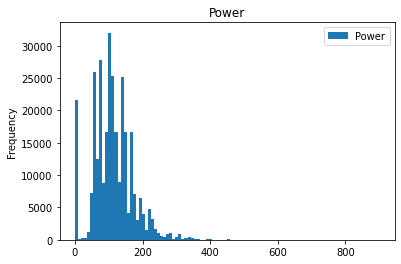

In [13]:
df.plot(kind='hist', y='Power', bins = 100, title='Power', range=(0, 900))
plt.show( )

In [14]:
df[df['Power']==0][['Power','Model']]

,Power,Model
0,0,golf
54,0,signum
55,0,astra
70,0,polo
90,0,a4
...,...,...
354335,0,corsa
354336,0,outlander
354346,0,c_klasse
354363,0,zafira


Удалим нулевые значения, что составляет 7% от оставшейся базы

In [15]:
df = df[df['Power']!=0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286167 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        286167 non-null  object
 1   Price              286167 non-null  int64 
 2   VehicleType        286167 non-null  object
 3   RegistrationYear   286167 non-null  int64 
 4   Gearbox            286167 non-null  object
 5   Power              286167 non-null  int64 
 6   Model              286167 non-null  object
 7   Kilometer          286167 non-null  int64 
 8   RegistrationMonth  286167 non-null  int64 
 9   FuelType           273405 non-null  object
 10  Brand              286167 non-null  object
 11  NotRepaired        247118 non-null  object
 12  DateCreated        286167 non-null  object
 13  NumberOfPictures   286167 non-null  int64 
 14  PostalCode         286167 non-null  int64 
 15  LastSeen           286167 non-null  object
dtypes: int64(7), object(

#### "Пробег"

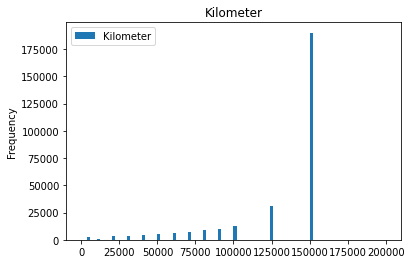

In [16]:
df.plot(kind='hist', y='Kilometer', bins = 100, title='Kilometer', range=(0, 200000))
plt.show( )

In [17]:
df[df['Kilometer']<5000][['Kilometer','Model']]

,Kilometer,Model


In [18]:
df[df['Kilometer']>150000][['Kilometer','Model']]

,Kilometer,Model


Явных выбросов нет.

#### "Тип топлива"

In [19]:
display(df['FuelType'].unique())

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заменим 'gasoline' на 'petrol'

In [20]:
df.replace(to_replace={'FuelType':{'gasoline':'petrol'}}, value = None, inplace = True)
display(df['FuelType'].unique())
display(df['FuelType'].isna().sum())
#display(df[df['FuelType'].isna()])

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

12762

Удалим пропуски, так как это около 4%

In [21]:
df.dropna(subset = ['FuelType'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273405 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        273405 non-null  object
 1   Price              273405 non-null  int64 
 2   VehicleType        273405 non-null  object
 3   RegistrationYear   273405 non-null  int64 
 4   Gearbox            273405 non-null  object
 5   Power              273405 non-null  int64 
 6   Model              273405 non-null  object
 7   Kilometer          273405 non-null  int64 
 8   RegistrationMonth  273405 non-null  int64 
 9   FuelType           273405 non-null  object
 10  Brand              273405 non-null  object
 11  NotRepaired        238929 non-null  object
 12  DateCreated        273405 non-null  object
 13  NumberOfPictures   273405 non-null  int64 
 14  PostalCode         273405 non-null  int64 
 15  LastSeen           273405 non-null  object
dtypes: int64(7), object(

#### "Ремонты"

Так как пропусков довольно много (12%), то удалять их не стоит. Заменим их на "no_info"

In [22]:
df['NotRepaired'] = df['NotRepaired'].fillna('no_info')
df['NotRepaired'].unique()

array(['no_info', 'no', 'yes'], dtype=object)

#### "Цена"
Посмотрим разбег целевого признака

In [23]:
df['Price'].describe()

count    273405.000000
mean       4938.896531
std        4659.262963
min           0.000000
25%        1375.000000
50%        3300.000000
75%        7190.000000
max       20000.000000
Name: Price, dtype: float64

## Обучение моделей

### Подготовка признаков

В признаки для обучения включим столбцы, кроме целевого и столбцов, которые не влияют на цену 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'.

In [24]:
X = df.drop(['Price', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
Y = df['Price']
X.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [25]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, train_size=0.75, random_state=RANDOM_STATE)
X_train.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_validation.reset_index(drop=True, inplace=True)
X_validation

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,sedan,2001,manual,192,3er,150000,petrol,bmw,no
1,sedan,2004,manual,105,golf,125000,petrol,volkswagen,no_info
2,sedan,2010,manual,102,a3,90000,petrol,audi,no
3,wagon,2005,auto,224,a6,150000,petrol,audi,no
4,sedan,2012,manual,140,a3,90000,petrol,audi,no
...,...,...,...,...,...,...,...,...,...
68347,sedan,1999,manual,105,3er,150000,petrol,bmw,no
68348,sedan,1993,manual,75,other,100000,petrol,renault,no
68349,sedan,1998,auto,170,e_klasse,150000,petrol,mercedes_benz,no
68350,sedan,1993,auto,75,golf,125000,petrol,volkswagen,no


### Параметры моделей
Зададим общие границы подбора параметров для всех моделей, а также количество корзин для кросс-валидации

In [26]:
ESTIMATORS = range (50, 151, 50)
DEPTH = range (2, 12, 2)
CV = 3

### Catboost

In [27]:
cat_features = [0,2,4,6,7,8]

In [28]:
model = CatBoostRegressor(random_state = RANDOM_STATE, cat_features = cat_features)

In [29]:
%%time

parameters = {'n_estimators': ESTIMATORS,
          'depth':  DEPTH
       }

start_time = datetime.now()
gsearch_cat_boost = GridSearchCV(estimator=CatBoostRegressor(), param_grid = parameters, scoring = 'neg_root_mean_squared_error', cv = CV,
          verbose=False, n_jobs = -1)
gsearch_cat_boost.fit(X_train, Y_train, cat_features=cat_features,verbose=False)
cat_boost_time_fit = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(cat_boost_time_fit))
print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n", -gsearch_cat_boost.best_score_)
print("\n The best parameters across ALL searched params:\n", gsearch_cat_boost.best_params_)

Time elapsed (hh:mm:ss.ms) 0:05:37.450472
 Results from Grid Search 

 The best score across ALL searched params:
 1712.8125099775316

 The best parameters across ALL searched params:
 {'depth': 10, 'n_estimators': 150}
CPU times: user 4min 44s, sys: 2.56 s, total: 4min 46s
Wall time: 5min 37s


In [30]:
start_time = datetime.now()
Y_pred = gsearch_cat_boost.predict(X_validation)
cat_boost_time_predict = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(cat_boost_time_predict))

Time elapsed (hh:mm:ss.ms) 0:00:00.145006


In [31]:
RMSE_catboost = mean_squared_error(Y_validation, Y_pred, squared = False)
print('RMSE', RMSE_catboost)

RMSE 1701.3064847395483


### LightGBM

Для LightGBM категориальные признаки нужно представить в виде целых чисел

In [32]:
encoder = OrdinalEncoder()
X_train_ordinal = pd.DataFrame(encoder.fit_transform(X_train[['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 
        'FuelType', 'Brand', 'NotRepaired']]),
                            columns=['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 
        'FuelType', 'Brand', 'NotRepaired'])
X_validation_ordinal = pd.DataFrame(encoder.fit_transform(X_validation[['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 
        'FuelType', 'Brand', 'NotRepaired']]),
                            columns=['VehicleType', 'RegistrationYear', 'Gearbox',  'Model', 
       'FuelType', 'Brand', 'NotRepaired'])
X_validation_ordinal

,VehicleType,RegistrationYear,Gearbox,Model,FuelType,Brand,NotRepaired
0,4.0,40.0,1.0,11.0,5.0,2.0,0.0
1,4.0,43.0,1.0,115.0,5.0,37.0,1.0
2,4.0,49.0,1.0,28.0,5.0,1.0,0.0
3,7.0,44.0,0.0,31.0,5.0,1.0,0.0
4,4.0,51.0,1.0,28.0,5.0,1.0,0.0
...,...,...,...,...,...,...,...
68347,4.0,38.0,1.0,11.0,5.0,2.0,0.0
68348,4.0,32.0,1.0,164.0,5.0,27.0,0.0
68349,4.0,37.0,0.0,95.0,5.0,20.0,0.0
68350,4.0,32.0,0.0,115.0,5.0,37.0,0.0


Заменим количественные признаки 'Kilometer','Power' в X_train_ordinal и X_validation_ordinal на данные до кодировки

In [33]:
X_train_ordinal['Kilometer'] = X_train['Kilometer']
X_train_ordinal['Power'] = X_train['Power']
X_validation_ordinal['Kilometer'] = X_validation['Kilometer']
X_validation_ordinal['Power'] = X_validation['Power']
X_validation_ordinal

,VehicleType,RegistrationYear,Gearbox,Model,FuelType,Brand,NotRepaired,Kilometer,Power
0,4.0,40.0,1.0,11.0,5.0,2.0,0.0,150000,192
1,4.0,43.0,1.0,115.0,5.0,37.0,1.0,125000,105
2,4.0,49.0,1.0,28.0,5.0,1.0,0.0,90000,102
3,7.0,44.0,0.0,31.0,5.0,1.0,0.0,150000,224
4,4.0,51.0,1.0,28.0,5.0,1.0,0.0,90000,140
...,...,...,...,...,...,...,...,...,...
68347,4.0,38.0,1.0,11.0,5.0,2.0,0.0,150000,105
68348,4.0,32.0,1.0,164.0,5.0,27.0,0.0,100000,75
68349,4.0,37.0,0.0,95.0,5.0,20.0,0.0,150000,170
68350,4.0,32.0,0.0,115.0,5.0,37.0,0.0,125000,75


In [ ]:
%%time

lgb_model = lgb.LGBMRegressor(RANDOM_STATE)
parameters = {
    'task': ['predict'],
    'boosting': ['gbdt' ],
    'num_iterations': ESTIMATORS,
   'max_depth':DEPTH
}

start_time = datetime.now()
gsearch_lgb = GridSearchCV(estimator=lgb_model, param_grid = parameters, n_jobs=-1, verbose=10, cv = CV)
gsearch_lgb.fit(X_train_ordinal ,Y_train, eval_metric='neg_root_mean_squared_error', categorical_feature= cat_features)
lgbm_time_fit = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(lgbm_time_fit))
print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n", gsearch_lgb.best_score_)
print("\n The best parameters across ALL searched params:\n", gsearch_lgb.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3; 1/15] START boosting=gbdt, max_depth=2, num_iterations=50, task=predict
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=11 will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[CV 1/3; 1/15] END boosting=gbdt, max_depth=2, num_iterations=50, task=predict; total time=  24.2s
[CV 2/3; 1/15] START boosting=gbdt, max_depth=2, num_iterations=50, task=predict
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=11 will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[CV 2/3; 1/15] END boosting=gbdt, max_depth=2, num_iterations=50, task=predict; total time=  23.8s
[CV 3/3; 1/15] START boosting=gbdt, max_depth=2, num_iterations=50, task=predict
[LightGBM]

In [57]:
start_time = datetime.now()
Y_pred = gsearch_lgb.predict(X_validation_ordinal)
lgbm_time_predict = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(lgbm_time_predict))

Time elapsed (hh:mm:ss.ms) 0:00:01.007419


In [58]:
RMSE_lgbm = mean_squared_error(Y_validation, Y_pred)**0.5
print('RMSE', RMSE_lgbm)

RMSE 1808.6426408997224


### RandomForestRegressor

In [59]:
forrest_model = RandomForestRegressor(random_state=RANDOM_STATE)

In [60]:
%%time

parameters = {'n_estimators': ESTIMATORS,
          'max_depth': DEPTH
       }

start_time = datetime.now()
gsearch_forrest = GridSearchCV(estimator=forrest_model, param_grid = parameters, cv = CV,
          verbose=False,scoring = 'neg_root_mean_squared_error', n_jobs = -1)
gsearch_forrest.fit(X_train_ordinal, Y_train)
forrest_time_fit = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(forrest_time_fit))
print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n", -gsearch_forrest.best_score_)
print("\n The best parameters across ALL searched params:\n", gsearch_forrest.best_params_)

Time elapsed (hh:mm:ss.ms) 0:07:46.910971
 Results from Grid Search 

 The best score across ALL searched params:
 1951.0175247058708

 The best parameters across ALL searched params:
 {'max_depth': 10, 'n_estimators': 150}
CPU times: user 7min 46s, sys: 241 ms, total: 7min 46s
Wall time: 7min 46s


In [61]:
start_time = datetime.now()
Y_pred = gsearch_forrest.predict(X_validation_ordinal)
forrest_time_predict = datetime.now() - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(forrest_time_predict))

Time elapsed (hh:mm:ss.ms) 0:00:00.840985


In [62]:
RMSE_forrest = mean_squared_error(Y_validation, Y_pred)**0.5
print('RMSE', RMSE_forrest)

RMSE 2001.2094491117498


## Анализ моделей

### Качество предсказаний.
Рассчитаем RMSE для простой модели, предсказывающей среднее значение.

In [63]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_ordinal, Y_train)
Y_pred = dummy_regr.predict(X_validation_ordinal)
print('RMSE', mean_squared_error(Y_validation, Y_pred)**0.5)

RMSE 4681.673619404378


Сравним с RMSE моделей

In [64]:
print ('RandomForestRegressor:', RMSE_forrest)
print ('LGBM:', RMSE_lgbm)
print ('CatBoost:', RMSE_catboost)

RandomForestRegressor: 2001.2094491117498
LGBM: 1808.6426408997224
CatBoost: 1701.3064847395483


Наилучшее качество модели у CatBoost, что гораздо лучше, чем у других моделей. Результат много лучше, чем у dummy-модели.

### Скорость обучения моделей

In [80]:
time_fit=[cat_boost_time_fit, lgbm_time_fit, forrest_time_fit]
time_predict=[cat_boost_time_predict, lgbm_time_predict, forrest_time_predict]
RMSE_list = [RMSE_catboost, RMSE_lgbm, RMSE_forrest]

[1701.3064847395483, 1808.6426408997224, 2001.2094491117498]

In [83]:
models = ['CatBoost', 'LightGBM', 'RandomForrest']
s = np.array([RMSE_list, time_predict,time_fit])
results = pd.DataFrame(s, index = ['Качество предсказания', 'Время предсказания', 'Время обучения'], columns = models )
results

,CatBoost,LightGBM,RandomForrest
Качество предсказания,1701.306485,1808.642641,2001.209449
Время предсказания,0:00:00.115723,0:00:01.007419,0:00:00.840985
Время обучения,0:04:36.354676,0:03:22.342134,0:07:46.910971


# Вывод
Качество предсказания и время предсказания наилучшие у CatBoost. Время обучения - у LGBM. Однако нужно учитывать, что для LGBM и RandomForestRegressor требуется кодирование категориальных признаков, а CatBoost делает это сам.
Таким образом, рекомендуемая модель - CatBoost.